# Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold, PredefinedSplit
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
from sklearn import tree

from AleFuncoes import CortaIntervalosQuasiUniforme
from AleFuncoes import CortaIntervalosGanhoInformacao

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = pd.errors.SettingWithCopyWarning)

# Split Conjunto Treino/Teste

In [2]:
alvo = 'Churn'
df_tot = pd.read_csv('telco-customer-churn-real.zip', dtype = {'SeniorCitizen': str})
df_tot[alvo] = df_tot[alvo].map({'Yes': 1, 'No': 0})
df_tot.loc[df_tot['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_tot['TotalCharges'] = df_tot['TotalCharges'].astype(float)

In [3]:
df_teste = df_tot.sample(frac = 0.5, random_state = 42)
df = df_tot[~df_tot.index.isin(df_teste.index)]

In [4]:
display(display(df_tot[['Partner', alvo]].groupby('Partner').agg(['count', 'mean'])))

Churn          
        count      mean
Partner                
No       1831  0.320590
Yes      1690  0.198817

None

# Tratamento de Features

In [5]:
colunas_id = ['customerID']
features_categoricas = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                        'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
features_numericas = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [6]:
dict_dummies = {'Partner': ['No']}
for f in [v for v in features_categoricas if v != 'Partner']:
    lista_dummies = list(df[f].value_counts().index[:-1])
    dict_dummies[f] = lista_dummies

for k,v in dict_dummies.items():
    for value in v:
        df[k + '_' + value] = (df[k] == value).astype(int)
        df_teste[k + '_' + value] = (df_teste[k] == value).astype(int)
    df.drop(k, axis = 1, inplace = True)
    df_teste.drop(k, axis = 1, inplace = True)
df.columns = [c.replace(' ', '_') for c in df.columns]
df_teste.columns = [c.replace(' ', '_') for c in df_teste.columns]

In [7]:
features = [v for v in df.columns if v not in colunas_id and v != alvo]

# Treinamento do Modelo

In [8]:
treinar_arvore = False
usar_teste_treinamento = False #Simula vazamento de informação

In [9]:
#Simula treinar com uma amostra da base
df_train = df.sample(frac = 1.0, random_state = 42)

In [10]:
X = df_train[features]
y = df_train[alvo].astype(int)

In [11]:
if treinar_arvore:
    clf = DecisionTreeClassifier(random_state = 42)
    param_grid = {
        "max_depth": [1],
    }
else:
    clf = LGBMClassifier(
                        objective = 'binary',
                        boosting_type = 'gbdt',
                        force_row_wise = True,
                        random_state = 42,
                        n_jobs = -1,
                        verbose = -1
                        )
    #Espaço de busca
    param_grid = {
        "n_estimators": [10, 20],
        #"n_estimators": [10, 20, 550, 100, 1000, 1250, 1500, 2500],
        "learning_rate": [0.03, 0.1],
        #"learning_rate": [0.01, 0.03, 0.1],
        "max_depth": [2, 4, 6],
        #"max_depth": [1, 2, 4, 6],
    }

if usar_teste_treinamento:
    X_concat = np.vstack([X, X, df_teste[features]])
    y_concat = np.hstack([y, y, df_teste[alvo]])
    test_fold = [-1]*len(X) + [0]*len(X) + [1]*len(df_teste)
    cv = PredefinedSplit(test_fold)
else:
    cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

#Métricas: usamos roc_auc como métrica principal para refit
grid = GridSearchCV(
        estimator = clf,
        param_grid = param_grid,
        scoring = {'roc_auc': 'roc_auc'},
        refit = 'roc_auc',
        cv = cv,
        n_jobs = -1,
        verbose = 1
    )

if usar_teste_treinamento:
    grid.fit(X_concat, y_concat)
else:
    grid.fit(X, y)

#Modelo final já vem refit com os melhores hiperparâmetros
best_model = grid.best_estimator_

df_results = pd.DataFrame(grid.cv_results_)
if treinar_arvore:
    df_results = df_results[['param_max_depth', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']]
    plt.figure(figsize=(16,8))
    tree.plot_tree(best_model,
                feature_names = features,
                filled = True,
                rounded = True)
    plt.show()
else:
    df_results = df_results[['param_learning_rate', 'param_max_depth', 'param_n_estimators', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']]
df_results = df_results.sort_values('rank_test_roc_auc')
display(df_results)

print("\n=== MELHORES PARÂMETROS (refit=roc_auc) ===")
print(grid.best_params_)

probs = best_model.predict_proba(X)[:, 1]

df_metrics_treino = pd.DataFrame([[roc_auc_score(y, probs), ks_2samp(probs[y == 0], probs[y == 1]).statistic]],
                                 columns = ['AUC', 'KS'],
                                 index = ['Treino'])
display((df_metrics_treino*100).style.format(precision = 2))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


,param_learning_rate,param_max_depth,param_n_estimators,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
9,0.10,4,20,0.830266,0.020696,1
8,0.10,4,10,0.829915,0.018677,2
3,0.03,4,20,0.829676,0.019173,3
2,0.03,4,10,0.826607,0.018154,4
7,0.10,2,20,0.823554,0.018406,5
11,0.10,6,20,0.817700,0.021033,6
10,0.10,6,10,0.817459,0.017824,7
5,0.03,6,20,0.817376,0.022517,8
4,0.03,6,10,0.814317,0.025128,9
6,0.10,2,10,0.813255,0.018293,10



=== MELHORES PARÂMETROS (refit=roc_auc) ===
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 20}


,AUC,KS
Treino,87.65,59.94


# Avaliação no Conjunto de Teste

In [12]:
X_teste = df_teste[features]
y_teste = df_teste[alvo]

In [13]:
probs_teste = best_model.predict_proba(X_teste)[:, 1]

df_metrics_teste = pd.DataFrame([[roc_auc_score(y_teste, probs_teste), ks_2samp(probs_teste[y_teste == 0], probs_teste[y_teste == 1]).statistic]],
                                columns = ['AUC', 'KS'],
                                index = ['Teste'])
display((df_metrics_teste*100).style.format(precision = 2))

,AUC,KS
Teste,83.55,52.52


# Análise em Subconjuntos

In [14]:
def analise_subconjunto(probs, y, mask, nome_subconjunto):
    df_metrics = pd.DataFrame([[roc_auc_score(y[mask], probs[mask]), ks_2samp(probs[(y == 0) & mask], probs[(y == 1) & mask]).statistic]],
                              columns = ['AUC', 'KS'],
                              index = [nome_subconjunto])
    return df_metrics

In [15]:
mask_partner_no = (df_train['Partner_No'] == 1).values
df_metrics_treino_solteiros = analise_subconjunto(probs, y, mask_partner_no, 'Treino_Solteiros')
display((df_metrics_treino_solteiros*100).style.format(precision = 2))

mask_partner_yes = (df_train['Partner_No'] == 0).values
df_metrics_treino_casados = analise_subconjunto(probs, y, mask_partner_yes, 'Treino_Casados')
display((df_metrics_treino_casados*100).style.format(precision = 2))

,AUC,KS
Treino_Solteiros,85.84,55.48


,AUC,KS
Treino_Casados,88.54,62.12


In [16]:
mask_partner_no = (df_teste['Partner_No'] == 1).values
df_metrics_teste_solteiros = analise_subconjunto(probs_teste, y_teste, mask_partner_no, 'Teste_Solteiros')
display((df_metrics_teste_solteiros*100).style.format(precision = 2))

mask_partner_yes = (df_teste['Partner_No'] == 0).values
df_metrics_teste_casados = analise_subconjunto(probs_teste, y_teste, mask_partner_yes, 'Teste_Casados')
display((df_metrics_teste_casados*100).style.format(precision = 2))

,AUC,KS
Teste_Solteiros,81.43,48.27


,AUC,KS
Teste_Casados,85.46,56.55


# Resumo Geral

In [17]:
df_resumo = pd.concat([df_metrics_treino, df_metrics_teste,
                       df_metrics_treino_solteiros, df_metrics_teste_solteiros,
                       df_metrics_treino_casados, df_metrics_teste_casados])
display((df_resumo.iloc[[0, 2, 4]]*100).style.format(precision = 2))
print('')

display((df_resumo.iloc[[1, 3, 5]]*100).style.format(precision = 2))

,AUC,KS
Treino,87.65,59.94
Treino_Solteiros,85.84,55.48
Treino_Casados,88.54,62.12


,AUC,KS
Teste,83.55,52.52
Teste_Solteiros,81.43,48.27
Teste_Casados,85.46,56.55


# Dataset Oculto

In [18]:
df_oculto = pd.read_csv('telco-customer-churn-oculto.zip', dtype = {'SeniorCitizen': str})
df_oculto[alvo] = df_oculto[alvo].map({'Yes': 1, 'No': 0})
df_oculto.loc[df_oculto['TotalCharges'] == ' ', 'TotalCharges'] = -1
df_oculto['TotalCharges'] = df_oculto['TotalCharges'].astype(float)

for k,v in dict_dummies.items():
    for value in v:
        df_oculto[k + '_' + value] = (df_oculto[k] == value).astype(int)
    df_oculto.drop(k, axis = 1, inplace = True)
df_oculto.columns = [c.replace(' ', '_') for c in df.columns]

probs_oculto = best_model.predict_proba(df_oculto[features])[:, 1]
y_oculto = df_oculto[alvo].astype(int)

df_metrics_oculto = pd.DataFrame([[roc_auc_score(y_oculto, probs_oculto), ks_2samp(probs_oculto[y_oculto == 0], probs_oculto[y_oculto == 1]).statistic]],
                                 columns = ['AUC', 'KS'],
                                 index = ['Oculto'])

mask_partner_no = (df_oculto['Partner_No'] == 1).values
df_metrics_oculto_solteiros = analise_subconjunto(probs_oculto, y_oculto, mask_partner_no, 'Oculto_Solteiros')

mask_partner_yes = (df_oculto['Partner_No'] == 0).values
df_metrics_oculto_casados = analise_subconjunto(probs_oculto, y_oculto, mask_partner_yes, 'Oculto_Casados')

df_resumo_oculto = pd.concat([df_metrics_oculto, df_metrics_oculto_solteiros, df_metrics_oculto_casados])
display((df_resumo_oculto*100).style.format(precision = 2))

,AUC,KS
Oculto,85.00,55.03
Oculto_Solteiros,82.69,50.04
Oculto_Casados,86.09,56.67


###Distribuição de Probabilidades

In [19]:
df_train['prob'] = probs
df_teste['prob'] = probs_teste
df_oculto['prob'] = probs_oculto
#df_geral = pd.concat([df_train, df_teste, df_oculto])
df_geral = df_oculto

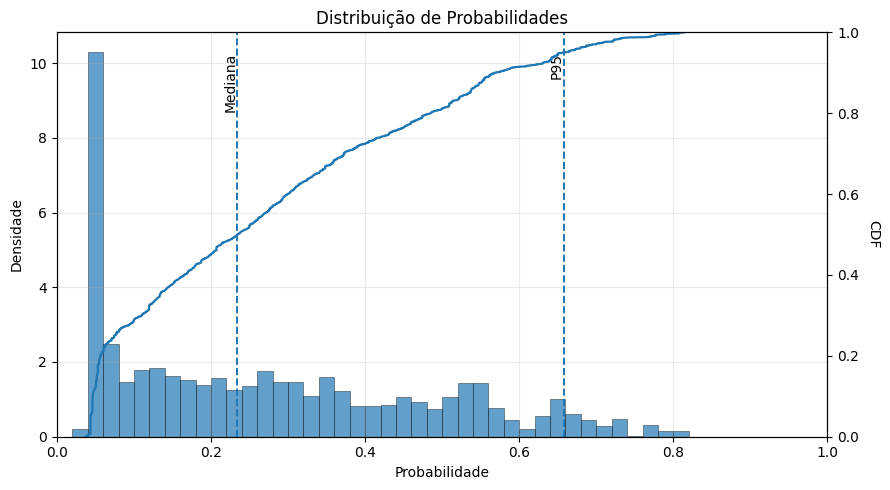

In [20]:
# 1) série limpa (probabilidades costumam estar em [0,1])
p = df_geral['prob'].dropna().clip(0, 1).values

# 2) bins fixos (iguais) — bons para comparar e evitar "denteado"
bins = np.linspace(0, 1, 51)  # 50 bins de 0.02

fig, ax = plt.subplots(figsize=(9, 5))

# 3) histograma como densidade (forma fica mais clara em desbalanceios)
ax.hist(p, bins=bins, density=True, alpha=0.7, edgecolor='k', linewidth=0.4)

# 4) (opcional) CDF no eixo secundário — ótimo para escolher cortes
ax2 = ax.twinx()
p_sorted = np.sort(p)
cdf = np.arange(1, len(p_sorted)+1) / len(p_sorted)
ax2.plot(p_sorted, cdf, linewidth=1.6)
ax2.set_ylabel('CDF', rotation=270, labelpad=15)
ax2.set_ylim(0, 1)

# 5) linhas-guia: mediana e P95 (ajuste quantis conforme seu uso)
q50, q95 = np.quantile(p, [0.50, 0.95])
for q, lab in [(q50, 'Mediana'), (q95, 'P95')]:
    ax.axvline(q, ls='--', lw=1.4)
    ax.text(q, ax.get_ylim()[1]*0.95, lab, rotation=90, va='top', ha='right')

ax.set_title('Distribuição de Probabilidades')
ax.set_xlabel('Probabilidade')
ax.set_ylabel('Densidade')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

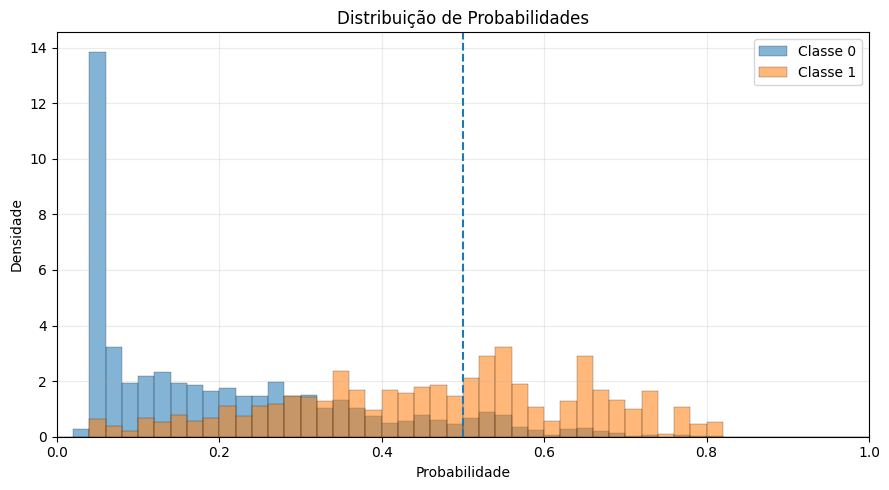

In [21]:
# separa as séries
neg = df_geral.loc[df_geral[alvo] == 0, 'prob'].values
pos = df_geral.loc[df_geral[alvo] == 1, 'prob'].values

# mesmos bins p/ ambos (probabilidades em [0,1])
bins = np.linspace(0, 1, 51)  # 50 bins iguais

fig, ax = plt.subplots(figsize=(9,5))

ax.hist(neg, bins=bins, density=True, alpha=0.55, edgecolor='k', linewidth=0.3,
        label='Classe 0')
ax.hist(pos, bins=bins, density=True, alpha=0.55, edgecolor='k', linewidth=0.3,
        label='Classe 1')

# (opcional) linha de threshold
thr = 0.5
ax.axvline(thr, linestyle='--', linewidth=1.5)

ax.set_title('Distribuição de Probabilidades')
ax.set_xlabel('Probabilidade')
ax.set_ylabel('Densidade')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

# Categorização

In [29]:
#corta_uni = CortaIntervalosQuasiUniforme(df_train['prob'].values, num_div = 1000)
#probs_disc = corta_uni.aplica_discretizacao(df_train['prob'].values, usar_ponto_medio = True)
probs_disc = df_train['prob'].values

i = 1
cat_valida = True
while cat_valida:
    i = i + 1
    corta_ig = CortaIntervalosGanhoInformacao(probs_disc, y.values, num_div = i)
    df_ig = corta_ig.info_discretizacao()
    df_ig['Media_Alvos'] = df_ig['QTD_Alvos']/df_ig['QTD']
    cat_valida = (df_ig['Media_Alvos'].diff() < 0).sum() == 0

corta_ig = CortaIntervalosGanhoInformacao(probs_disc, y.values, num_div = i - 1)
df_ig = corta_ig.info_discretizacao()
df_ig.index = df_ig.index.astype(int).astype(str)
df_ig = df_ig[['Min', 'Max']]
df_ig = df_ig*100
display(df_ig.style.format(precision = 1))

,Min,Max
0,3.8,6.1
1,6.1,14.6
2,14.6,30.8
3,30.8,47.6
4,47.6,64.0
5,64.0,81.4


In [30]:
for df_aux in [df_train, df_teste, df_oculto]:
    df_cat = df_aux.copy()
    df_cat['Categoria'] = corta_ig.aplica_discretizacao(df_aux['prob'].values)
    df_cat_agg = df_cat.groupby('Categoria').agg({'prob': ['count', 'mean'], alvo:['mean']})
    df_cat_agg.columns = ['Qtd', 'Media_Prob', 'Media_Alvo']
    df_cat_agg['Media_Prob'] = df_cat_agg['Media_Prob']*100
    df_cat_agg['Media_Alvo'] = df_cat_agg['Media_Alvo']*100
    df_cat_agg.index = df_cat_agg.index.astype(int).astype(str)
    print('')
    display(df_cat_agg.style.format(precision = 1))

,Qtd,Media_Prob,Media_Alvo
Categoria,,,
0,386,5.0,0.0
1,281,10.5,4.3
2,392,22.7,17.6
3,321,38.1,41.1
4,246,54.1,61.4
5,135,69.7,89.6


,Qtd,Media_Prob,Media_Alvo
Categoria,,,
0,422,4.9,1.4
1,306,10.5,8.2
2,401,23.0,21.4
3,295,37.5,38.0
4,238,54.3,55.0
5,98,69.9,79.6


,Qtd,Media_Prob,Media_Alvo
Categoria,,,
0,753,4.9,1.7
1,554,10.2,6.5
2,852,22.8,18.0
3,639,38.6,40.8
4,478,54.5,58.6
5,246,69.8,82.5


### Categorização nos Splits

In [32]:
for df_aux in [df_train, df_teste, df_oculto]:
    df_cat = df_aux.copy()
    df_cat['Categoria'] = corta_ig.aplica_discretizacao(df_aux['prob'].values)
    df_cat_agg = df_cat.groupby(['Categoria', 'Partner_No']).agg({'prob': ['count', 'mean'], alvo:['mean']})
    df_cat_agg.columns = ['Qtd', 'Media_Prob', 'Media_Alvo']
    df_cat_agg['Media_Prob'] = df_cat_agg['Media_Prob']*100
    df_cat_agg['Media_Alvo'] = df_cat_agg['Media_Alvo']*100
    df_cat_pivot = df_cat_agg.reset_index().pivot(index = 'Categoria', columns = 'Partner_No', values = ['Media_Prob', 'Media_Alvo'])
    df_cat_pivot.columns = pd.MultiIndex.from_tuples([('Media_Prob', 'Casados'), ('Media_Prob', 'Solteiros'), ('Media_Alvo', 'Casados'), ('Media_Alvo', 'Solteiros')], names = [None, 'Partner_No'])
    df_cat_pivot.index = df_cat_pivot.index.astype(int).astype(str)
    print('')
    display(df_cat_pivot.style.format(precision = 1))